# Finely-Tuned BERT Model - Automatic Grading & Plagiarism Detection (Dataset 2)

Omar Ebrahim - 202000443

# A) Automatic Grading

1. Importing libraries

In [1]:
import torch
import pandas as pd
from transformers import BertTokenizer, BertModel
from torch.utils.data import DataLoader, Dataset
import numpy as np

from peft import LoraConfig, TaskType, get_peft_model

from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr 
from sklearn.metrics import mean_absolute_error

c:\Users\Omar\anaconda3\envs\CS4120\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2. Importing dataset and tokenizer

In [2]:
df = pd.read_csv("C:/Users/Omar/OneDrive/Desktop/my_dataset.csv")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

3. Creating custom dataset, where student answers and sample answers are will be tokenized and added to this new dataset alongside its corresponding questions and scores.

In [3]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        question = str(self.data.loc[index, 'Question'])
        correct_code = str(self.data.loc[index, 'Correct_Code'])
        code_with_error = str(self.data.loc[index, 'Code_with_Error'])
        total_marks = self.data.loc[index, 'Total_Marks']
        
        inputs = self.tokenizer(correct_code,
                                add_special_tokens=True, 
                                max_length=self.max_length, 
                                padding='max_length', 
                                truncation=True, 
                                return_tensors='pt')
        
        inputs2 = self.tokenizer(code_with_error,
                                 add_special_tokens=True, 
                                 max_length=self.max_length, 
                                 padding='max_length', 
                                 truncation=True, 
                                 return_tensors='pt')
        
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'input_ids2': inputs2['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'attention_mask2': inputs2['attention_mask'].flatten(),
            'total_marks': torch.tensor(total_marks, dtype=torch.float)
        }

dataset = CustomDataset(df, tokenizer)

In [4]:
model = BertModel.from_pretrained('bert-base-uncased')

4. Setting up the LoRA fine-tuning configuration

In [5]:
lora_config = LoraConfig(
    task_type=TaskType.FEATURE_EXTRACTION, # Task type for which the model will undergo fine-tuning
    r=1,  # Dimensions of A and B (A = mxr, B=rxn)
    lora_alpha=1,  # Scaling factor determining the relative significance of weights in A and B
    lora_dropout=0.1  # Dropout probability for LoRA
)

5. Recreating the BERT Model, this time fine-tuned with less trainable parameters thanks to LoRA Fine-Tuning

In [6]:
model = get_peft_model(model, lora_config)
model.eval()

PeftModelForFeatureExtraction(
  (base_model): LoraModel(
    (model): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): lora.Linear(
                  (base_layer): Linear(in_features=768, out_features=768, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Dropout(p=0.1, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=768, out_features=1, bias=False)
                  )
                 

6. Generating word embeddings using finely-tuned BERTModel

In [7]:
BMwordEmbeddings1 = []
BMwordEmbeddings2 = []

with torch.no_grad():
    for example in DataLoader(dataset, batch_size=1):
        input_ids = example['input_ids']
        attention_mask = example['attention_mask']

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = outputs.last_hidden_state
        BMwordEmbeddings1.append(embeddings.squeeze().detach().numpy())

    for example in DataLoader(dataset, batch_size=1):
        input_ids2 = example['input_ids2']
        attention_mask2 = example['attention_mask2']

        outputs = model(input_ids=input_ids2, attention_mask=attention_mask2)
        embeddings = outputs.last_hidden_state
        BMwordEmbeddings2.append(embeddings.squeeze().detach().numpy())

BMwordEmbeddings1 = np.array(BMwordEmbeddings1)
BMwordEmbeddings2 = np.array(BMwordEmbeddings2)

np.save('BMwordEmbeddings1.npy', BMwordEmbeddings1)
np.save('BMwordEmbeddings2.npy', BMwordEmbeddings2)

7. Evaluation:
   1. Generating the new scores by doing cosine similarity between embedded student answers and embedded model answers (rescaled between 1-10)
   2. After getting both scores, we compare them using using MAE and Pearson correlation
   3. MAPE was used additionally to see the % difference between both grades per row

In [8]:
MAE = []
MAPE = []
Pearson = []
predicted_scores = []

BMwordEmbeddings1 = np.load('BMwordEmbeddings1.npy', allow_pickle=True)
BMwordEmbeddings2 = np.load('BMwordEmbeddings2.npy', allow_pickle=True)

print("Original Score | Predicted Score | MAPE (%)")
print("--------------------------------------------")
for i in range(len(BMwordEmbeddings1)):
    BMWordEmbeddings1_i = BMwordEmbeddings1[i].reshape(1, -1)
    BMWordEmbeddings2_i = BMwordEmbeddings2[i].reshape(1, -1)

    similarity = cosine_similarity(BMWordEmbeddings1_i, BMWordEmbeddings2_i)[0][0]
    
    scaled_similarity = similarity * 10

    predicted_score = max(min(scaled_similarity, 10), 0)
    original_score = df['Total_Marks'][i]

    mape = np.abs((predicted_score - original_score) / original_score) * 100

    print(f"{original_score:.2f}           | {predicted_score:.2f}            | {mape:.2f}")

    MAE.append(np.abs(predicted_score - original_score))
    MAPE.append(mape)
    Pearson.append((original_score, predicted_score))
    predicted_scores.append(predicted_score)

MAE = np.mean(MAE)
MAPE = np.mean(MAPE)
pearson_corr = np.array(Pearson)
corr_coefficient, _ = pearsonr(pearson_corr[:,0], pearson_corr[:,1])

print(f"\nMean Absolute Error: {MAE:.2f}")
print(f"Pearson Correlation: {corr_coefficient:.2f}")

Original Score | Predicted Score | MAPE (%)
--------------------------------------------
10.00           | 5.07            | 49.25
8.00           | 9.16            | 14.48
8.00           | 7.83            | 2.18
8.00           | 6.30            | 21.28
8.00           | 7.40            | 7.49
10.00           | 8.12            | 18.84
6.00           | 8.66            | 44.27
10.00           | 8.50            | 14.97
10.00           | 7.86            | 21.38
10.00           | 7.86            | 21.38
8.00           | 7.75            | 3.06
8.00           | 6.73            | 15.82
8.00           | 6.85            | 14.43
10.00           | 5.91            | 40.94
0.00           | 6.78            | inf
10.00           | 5.82            | 41.82
7.00           | 6.23            | 10.95
8.00           | 6.23            | 22.09
0.00           | 6.23            | inf
0.00           | 6.23            | inf
8.00           | 6.64            | 16.99
10.00           | 10.00            | 0.00
6.00      

C:\Users\Omar\AppData\Local\Temp\ipykernel_20828\142130757.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  mape = np.abs((predicted_score - original_score) / original_score) * 100
C:\Users\Omar\AppData\Local\Temp\ipykernel_20828\142130757.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  mape = np.abs((predicted_score - original_score) / original_score) * 100
C:\Users\Omar\AppData\Local\Temp\ipykernel_20828\142130757.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  mape = np.abs((predicted_score - original_score) / original_score) * 100
C:\Users\Omar\AppData\Local\Temp\ipykernel_20828\142130757.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  mape = np.abs((predicted_score - original_score) / original_score) * 100
C:\Users\Omar\AppData\Local\Temp\ipykernel_20828\142130757.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  mape = np.abs((predicted_score - original_score) / original_score) *

8. Visualizaing BERT-grading distribution vs. manual-grading distribution

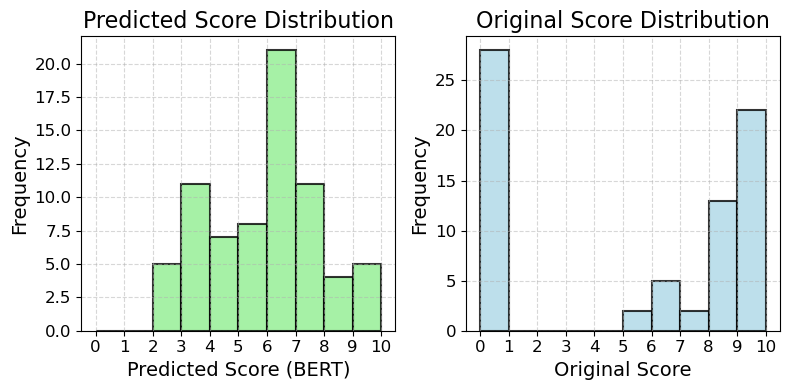

In [9]:
import matplotlib.pyplot as plt

bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.hist(predicted_scores, bins=bins, color='lightgreen', edgecolor='black', alpha=0.8, linewidth=1.5)
plt.xlabel('Predicted Score (BERT)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Predicted Score Distribution', fontsize=16)
plt.xticks(bins, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

plt.subplot(1, 2, 2)
plt.hist(df['Total_Marks'], bins=bins, color='lightblue', edgecolor='black', alpha=0.8, linewidth=1.5)
plt.xlabel('Original Score', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Original Score Distribution', fontsize=16)
plt.xticks(bins, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# B) Plagiarism Detection

1. Creating a new custom dataset, this time we only need to tokenize student answers.

In [10]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        code_with_error = str(self.data.loc[index, 'Code_with_Error'])
        student = self.data.loc[index, 'Student']
        
        inputs = self.tokenizer(code_with_error,
                                add_special_tokens=True, 
                                max_length=self.max_length, 
                                padding='max_length', 
                                truncation=True, 
                                return_tensors='pt')
        
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'student': student
        }

dataset = CustomDataset(df, tokenizer)

2. Preparing the BERTModel to generate embeddings

In [11]:
model = BertModel.from_pretrained('bert-base-uncased')

3. Generating student embeddings using BERTModel, this time each student is referenced to make sure the embeddings are correctly assigned to the correct student.

In [20]:
studentEmbeddings = {}

with torch.no_grad():
    for i, example in enumerate(DataLoader(dataset, batch_size=1)):
        input_ids = example['input_ids']
        attention_mask = example['attention_mask']
        student = df.loc[i, 'Student']
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = outputs.last_hidden_state.squeeze().detach().numpy()
        
        if student not in studentEmbeddings:
            studentEmbeddings[student] = []
        studentEmbeddings[student].append(embeddings)

for i, (student, embeddings) in enumerate(studentEmbeddings.items()):
    np.save(f'student_{i+1}_code_with_error_embeddings.npy', np.array(embeddings))

for i, (student, embeddings) in enumerate(studentEmbeddings.items()):
    print(f"Student {i+1} Embeddings:")
    print(embeddings)

Student 1 Embeddings:
[array([[-0.38660216, -0.61724776, -0.1112853 , ..., -0.45697144,
        -0.23751307,  1.2205533 ],
       [-0.05482256, -0.5933449 , -0.15866747, ...,  0.24164595,
        -0.2666211 ,  0.4380745 ],
       [-1.0709692 , -0.7585768 ,  0.12087308, ..., -0.10196998,
         0.15748234,  1.4926146 ],
       ...,
       [-0.32549328, -0.83544075, -0.2233719 , ...,  0.23858142,
         0.16917902,  0.23436134],
       [-0.3737327 , -0.8266603 , -0.21696538, ...,  0.1881783 ,
         0.16159797,  0.18144166],
       [-0.41048306, -0.8189667 , -0.28568405, ...,  0.09704926,
         0.10300209,  0.19225973]], dtype=float32), array([[-0.29181978, -0.51828045,  0.27488372, ..., -0.49400547,
        -0.2284565 ,  0.89411217],
       [-0.13460131, -0.6412582 , -0.19479258, ...,  0.20490263,
        -0.12888902,  0.10622613],
       [-0.2233583 ,  0.14845377,  0.39581951, ..., -0.3988148 ,
        -0.49657306,  0.71902907],
       ...,
       [ 0.02219107, -0.659814  ,  0

4. Performing cosine similarity to compare between combinations of 2 students at a time per question (0: no similarity, 1: perfect similarity)

In [85]:
import os
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity

studentEmbeddings = {}
for filename in os.listdir('.'):
    if filename.endswith('.npy'):
        split_filename = filename.split('_')
        if len(split_filename) >= 3 and split_filename[-1] == 'embeddings.npy':
            student_id = int(split_filename[1])
            embeddings = np.load(filename, allow_pickle=True)
            studentEmbeddings[student_id] = embeddings
        else:
            print(f"Issue with filename: {filename}") # (Making sure the correct files that have the embeddings are called.)

num_questions = len(next(iter(studentEmbeddings.values())))

for question_index in range(num_questions):
    print(f"Question {question_index + 1}")
    

    question_embeddings = [studentEmbeddings[student_id][question_index] for student_id in studentEmbeddings]
    for student_pair in combinations(studentEmbeddings.keys(), 2):
        student1_id, student2_id = student_pair
        student1_embeddings = studentEmbeddings[student1_id][question_index]
        student2_embeddings = studentEmbeddings[student2_id][question_index]
        
        similarity = cosine_similarity(student1_embeddings.reshape(1, -1), student2_embeddings.reshape(1, -1))[0][0]
        
        print(f"Student {student1_id} vs. Student {student2_id} Similarity: {similarity:.4f}")


Issue with filename: BMwordEmbeddings1.npy
Issue with filename: BMwordEmbeddings2.npy
Issue with filename: Student 1_embeddings.npy
Issue with filename: Student 2_embeddings.npy
Issue with filename: Student 3_embeddings.npy
Issue with filename: Student 4_embeddings.npy
Question 1
Student 1 vs. Student 2 Similarity: 0.5149
Student 1 vs. Student 3 Similarity: 0.5262
Student 1 vs. Student 4 Similarity: 0.4750
Student 2 vs. Student 3 Similarity: 0.8510
Student 2 vs. Student 4 Similarity: 0.6222
Student 3 vs. Student 4 Similarity: 0.6179
Question 2
Student 1 vs. Student 2 Similarity: 0.7051
Student 1 vs. Student 3 Similarity: 0.6887
Student 1 vs. Student 4 Similarity: 0.7942
Student 2 vs. Student 3 Similarity: 0.7704
Student 2 vs. Student 4 Similarity: 0.8290
Student 3 vs. Student 4 Similarity: 0.7797
Question 3
Student 1 vs. Student 2 Similarity: 1.0000
Student 1 vs. Student 3 Similarity: 0.8433
Student 1 vs. Student 4 Similarity: 0.6632
Student 2 vs. Student 3 Similarity: 0.8433
Student 2

5. Visualizing the results via a confusion matrix for each question (Total 18)

C:\Users\Omar\AppData\Local\Temp\ipykernel_20828\3459981466.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


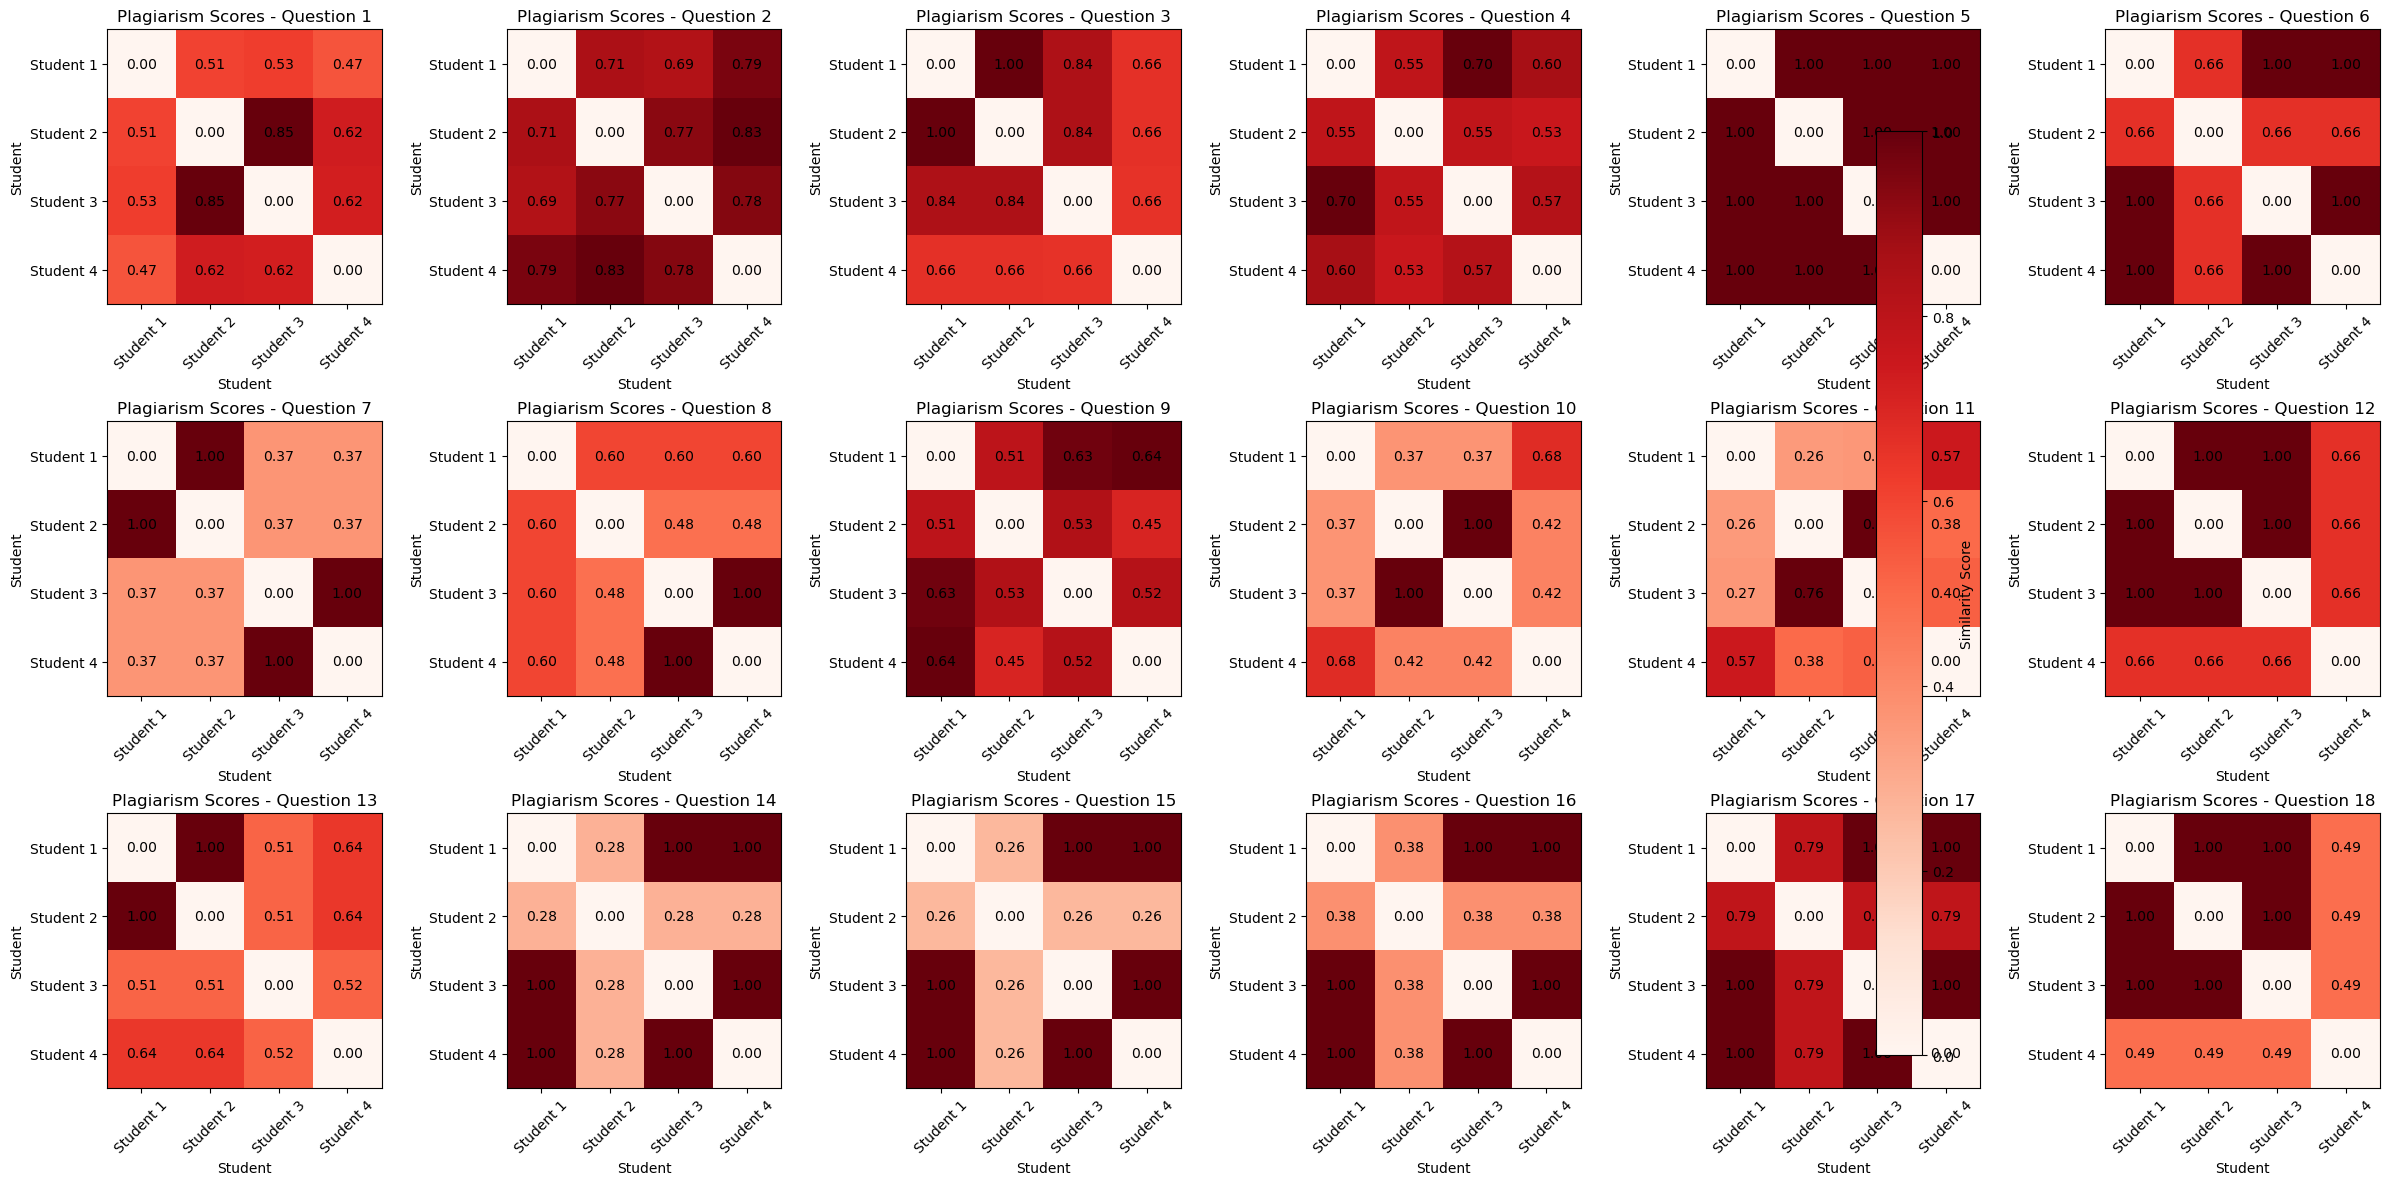

In [87]:
import matplotlib.pyplot as plt
import numpy as np

num_rows = (num_questions // 2) + (num_questions % 2 > 0)
num_cols = min(num_questions, 6)

fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(24, 12))

for question_index, (question, scores) in enumerate(plagiarism_scores.items()):
    scores_matrix = np.zeros((4, 4))
    k = 0
    for i in range(4):
        for j in range(i + 1, 4):
            scores_matrix[i, j] = scores[k]
            scores_matrix[j, i] = scores[k]
            k += 1
    
    row_index = question_index // 6
    col_index = question_index % 6
    ax = axes[row_index, col_index]
    im = ax.imshow(scores_matrix, cmap='Reds')
    
    for i in range(4):
        for j in range(4):
            ax.text(j, i, f'{scores_matrix[i, j]:.2f}', ha='center', va='center', color='black')
    
    ax.set_title(f'Plagiarism Scores - {question}')
    ax.set_xticks(range(4))
    ax.set_xticklabels([f'Student {i+1}' for i in range(4)], rotation=45)
    ax.set_yticks(range(4))
    ax.set_yticklabels([f'Student {i+1}' for i in range(4)])
    ax.set_xlabel('Student')
    ax.set_ylabel('Student')
    ax.grid(False)

cbar = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='vertical')
cbar.set_label('Similarity Score')

plt.tight_layout()
plt.show()

0: no similarity, 1: perfect similarity